# Standard imports and functions

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import mplhep as hep
hep.style.use(hep.style.ATLAS)

from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification, make_circles
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, accuracy_score, roc_auc_score, roc_curve, RocCurveDisplay

import tensorflow as tf
from tensorflow import keras

from sklearn.preprocessing import StandardScaler

In [2]:
def my_plot_roc_curve(model, X_test, y_test):
    if hasattr(model, "predict_proba"):
        y_scores = model.predict_proba(X_test)
    else:
        y_scores = model.predict(X_test)

    if len(y_scores.shape) == 2:
        if y_scores.shape[1] == 1:
            y_scores = y_scores.reshape(-1)
        elif y_scores.shape[1] == 2:
            y_scores = y_scores[:,1].reshape(-1)
    fpr, tpr, _ = roc_curve(y_test, y_scores)
    roc_auc = roc_auc_score(y_test, y_scores)
    plt.clf()
    display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=model.__class__.__name__)
    display.plot()
    plt.plot([0, 1], [0, 1], color='black', linestyle='--')
    plt.savefig("Roc Curve.pdf")
    plt.show()

# Loading the datasets
A background dataset and 4 different signals were loaded into the notebook for further analysis.

In [3]:
monotopSignal=pd.read_csv('ResmMed4000mX1lb0p2yp0p4.csv',delimiter=',',index_col=0) 
guinoSignal=pd.read_csv('GG_direct_2000_0.csv',delimiter=',',index_col=0) 
tripletSignal=pd.read_csv('HVT_Agv1_VzZH_vvqq_m1000.csv',delimiter=',',index_col=0) 
higgsSignal=pd.read_csv('bbA2000_yb2_Zhvvbb.csv',delimiter=',',index_col=0) 
print("Signals loaded")
background=pd.read_csv('bkg.csv',delimiter=',',index_col=0)
print("Background loaded")

Signals loaded
Background loaded


# Feature Selection
In order for the neural network to work, all datasets must all contain the same features. Any features which were not present in all datasets were removed.

In [4]:
newBackground=pd.DataFrame(background,columns=tripletSignal.columns)
newSignal=pd.DataFrame(monotopSignal,columns=tripletSignal.columns)
newBackground.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10316120 entries, 1729653 to 12045772
Data columns (total 44 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   jet_DL1r_max              float64
 1   normalisedCombinedWeight  float64
 2   jet_e                     float64
 3   mcChannelNumber           int64  
 4   topjet_pt                 float64
 5   MET_eta                   float64
 6   topjet_e                  float64
 7   ljet_m                    float64
 8   nLumi                     float64
 9   MET                       float64
 10  topjet_phi                float64
 11  jet_eta                   float64
 12  ljet_py                   float64
 13  ljet_phi                  float64
 14  ljet_pz                   float64
 15  DeltaR_max                float64
 16  combinedWeight            float64
 17  squaredCombinedWeight     float64
 18  ljet_eta                  float64
 19  ljet_pt                   float64
 20  jet_pt               

In [5]:
newBackground=newBackground.drop(['combinedWeight','squaredCombinedWeight','gen_sample','category','merge_sample','positiveCombinedWeight','MET_m','MET_eta','mcChannelNumber','mc_channel','nLumi','topjet_phi', 'mtop', 'topjet_eta', 'topjet_m'],axis='columns')
newSignal=newSignal.drop(['combinedWeight','squaredCombinedWeight','gen_sample','category','merge_sample','positiveCombinedWeight','MET_m','MET_eta','mcChannelNumber','mc_channel','nLumi','topjet_phi', 'mtop', 'topjet_eta', 'topjet_m'],axis='columns')
guinoSignal=guinoSignal.drop(['combinedWeight','squaredCombinedWeight','gen_sample','category','merge_sample','positiveCombinedWeight','MET_m','MET_eta','mcChannelNumber','mc_channel','nLumi','topjet_phi', 'mtop', 'topjet_eta', 'topjet_m'],axis='columns')
tripletSignal=tripletSignal.drop(['combinedWeight','squaredCombinedWeight','gen_sample','category','merge_sample','positiveCombinedWeight','MET_m','MET_eta','mcChannelNumber','mc_channel','nLumi','topjet_phi', 'mtop', 'topjet_eta', 'topjet_m'],axis='columns')
higgsSignal=higgsSignal.drop(['combinedWeight','squaredCombinedWeight','gen_sample','category','merge_sample','positiveCombinedWeight','MET_m','MET_eta','mcChannelNumber','mc_channel','nLumi','topjet_phi', 'mtop', 'topjet_eta', 'topjet_m'],axis='columns')

# Plotting the data

Kinematic distributions and correlations were checked to ensure adequate features were chosen.

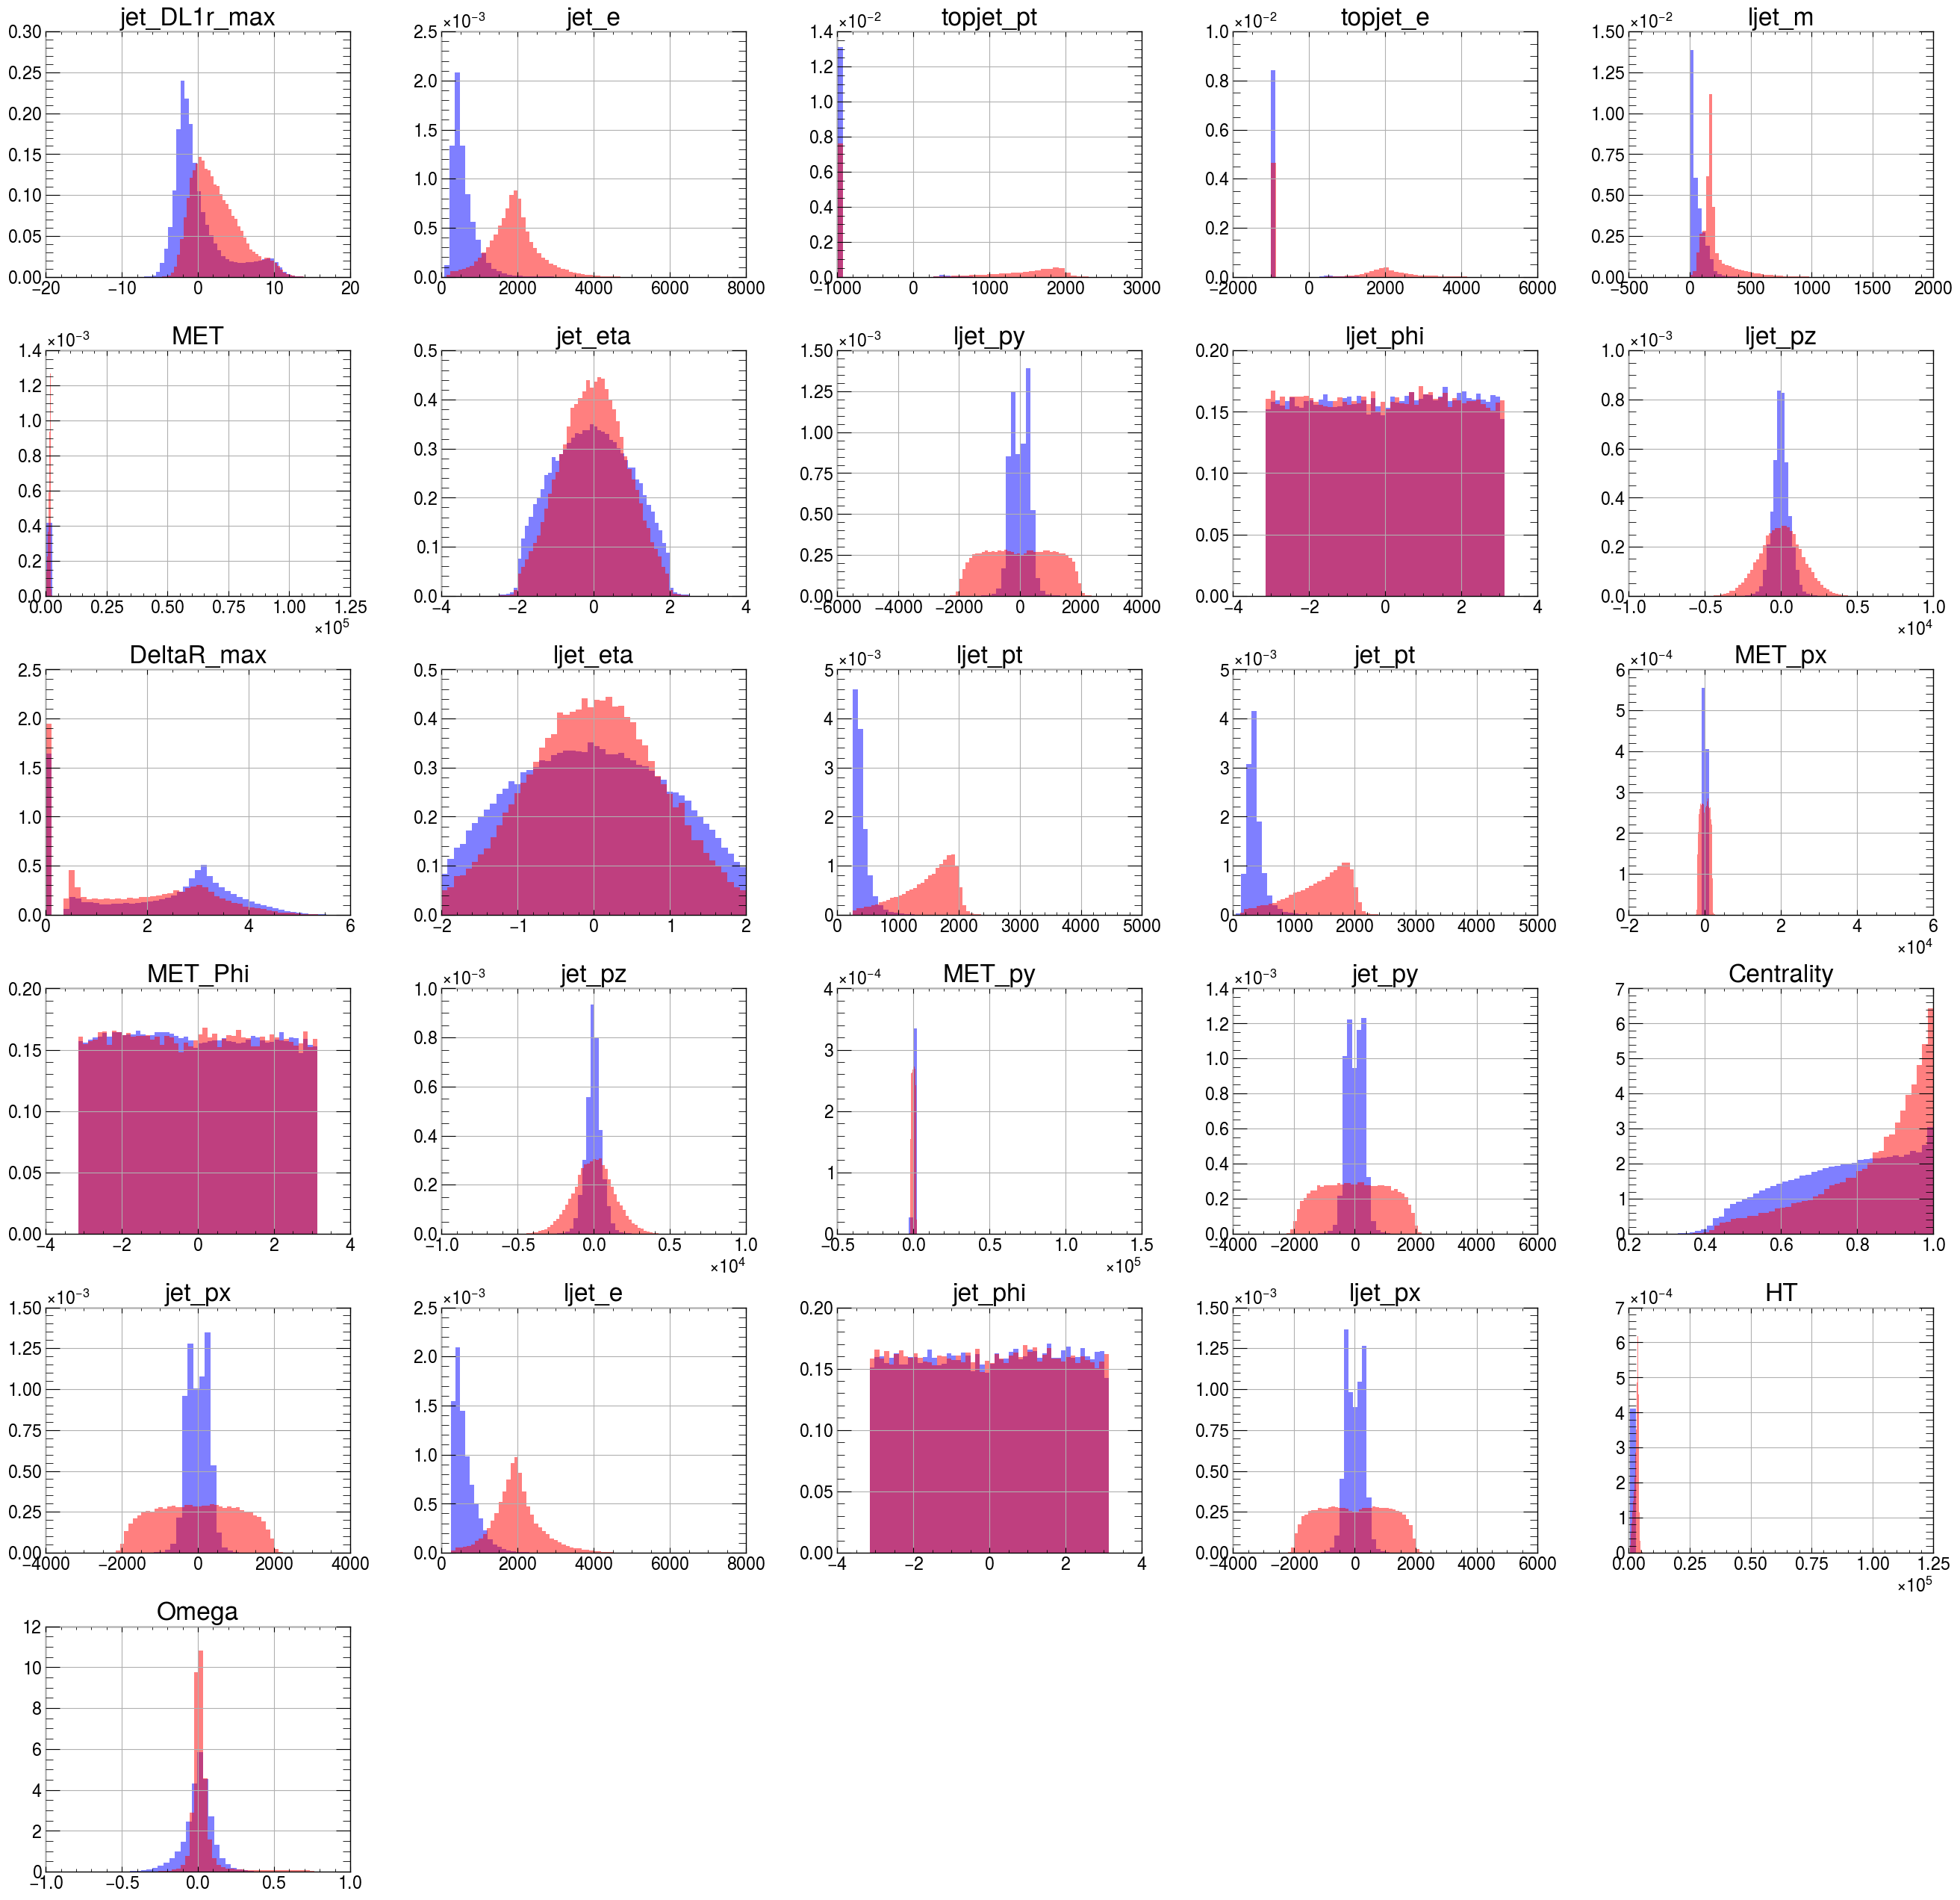

In [6]:
plotBackground=newBackground.drop(['normalisedCombinedWeight','train_weight','gen_split'],axis='columns')
plotSignal=newSignal.drop(['normalisedCombinedWeight','train_weight','gen_split'],axis='columns')
ax=plotBackground.hist(weights=newBackground['normalisedCombinedWeight'],figsize=(32,32),bins=50,color='b',alpha=0.5,density=True,label="B")
ax=ax.flatten()[:plotBackground.shape[1]] # to avoid error if holes in the grid of plots (like if 7 or 8 features)
plotSignal.hist(weights=newSignal['normalisedCombinedWeight'],figsize=(32,32),bins=50,color='r',alpha=0.5,density=True,ax=ax,label="S");
plt.savefig("Histograms of Variables.pdf")

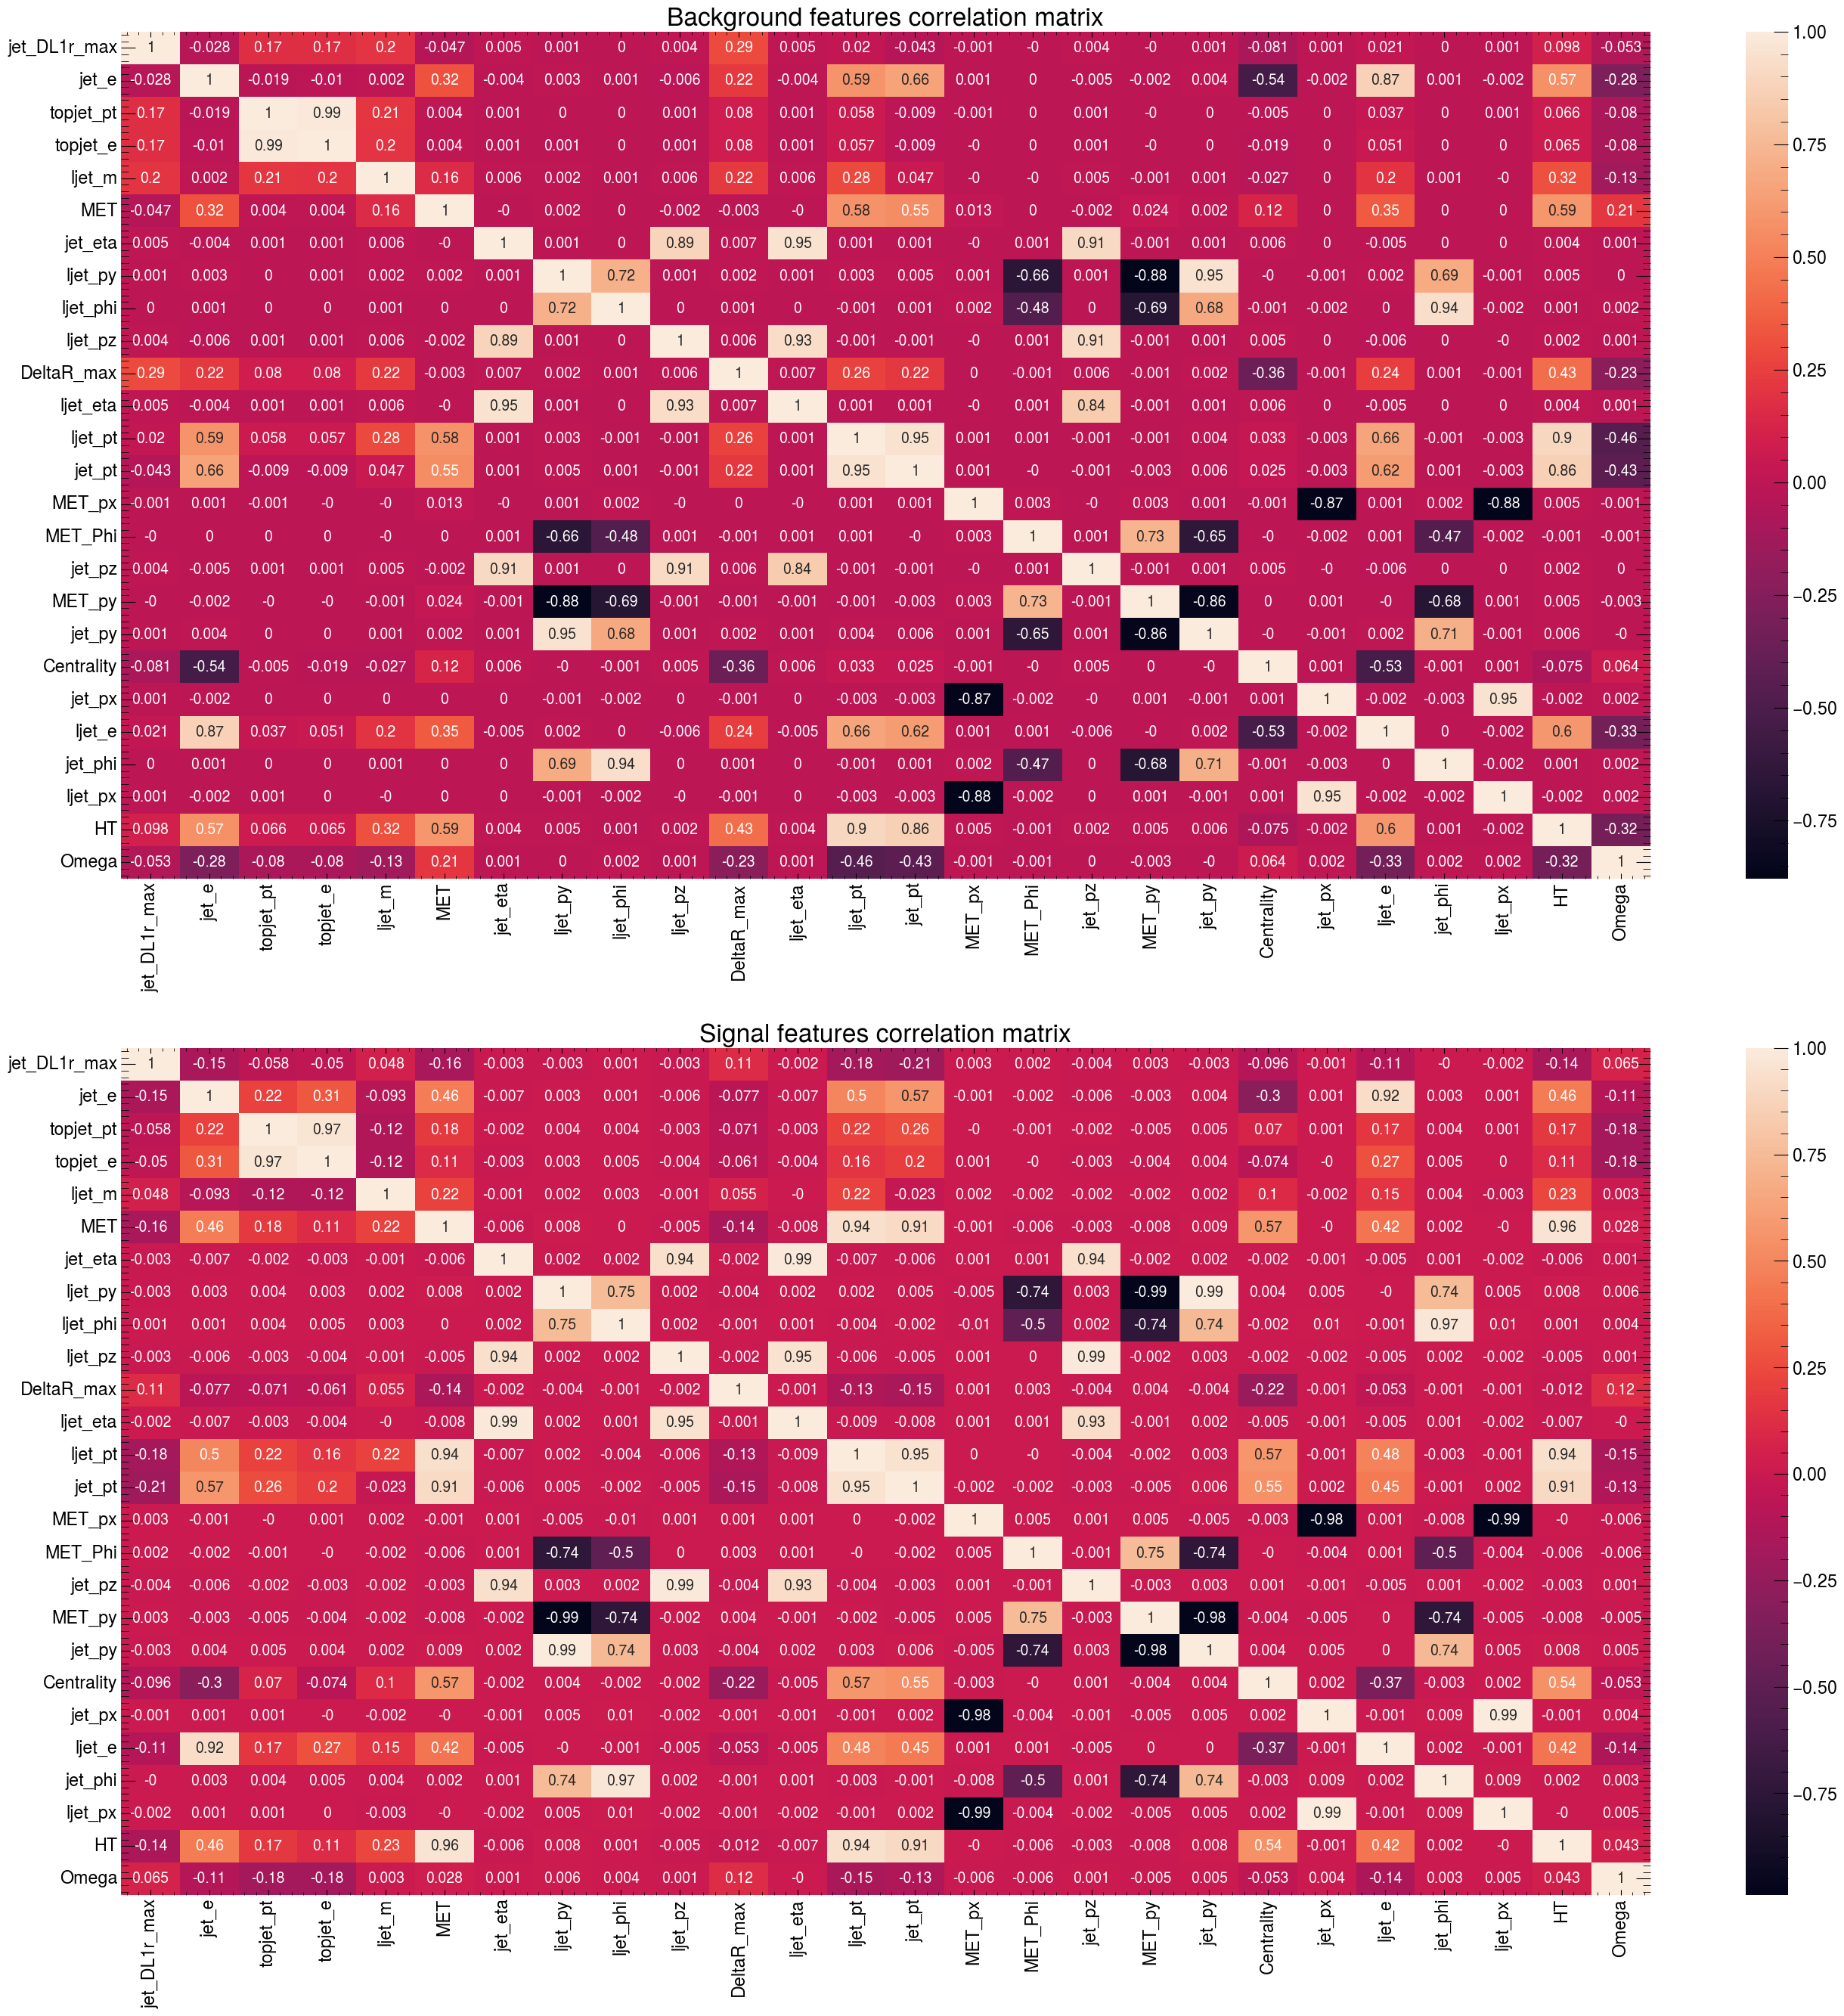

In [ ]:
correlationBackground=newBackground.drop(['normalisedCombinedWeight','train_weight','gen_split'],axis='columns')
correlationSignal=newSignal.drop(['normalisedCombinedWeight','train_weight','gen_split'],axis='columns')

fig,ax=plt.subplots(2, 1, figsize=(32,32))

corrMatrix = correlationBackground.corr()
ax[0].set_title("Background features correlation matrix")
sns.heatmap(corrMatrix.round(3), ax=ax[0], annot=True);

corrMatrix = correlationSignal.corr()
ax[1].set_title("Signal features correlation matrix")
sns.heatmap(corrMatrix.round(3), ax=ax[1], annot=True);
plt.savefig("correlation matrix")

# Splitting and labelling the data

The data was split into training, validation and testing data sets. These were then combined so that the background and monotop would be considered in one dataset. 

In [8]:
#separating background data
testBackground=newBackground.loc[newBackground['gen_split'] == 'test']
trainBackground=newBackground.loc[newBackground['gen_split'] == 'train']
validBackground=newBackground.loc[newBackground['gen_split'] == 'val']
print("Background data separated")


#separating signal data
testSignalM=newSignal.loc[newSignal['gen_split'] == 'test']
trainSignalM=newSignal.loc[newSignal['gen_split'] == 'train']
validSignalM=newSignal.loc[newSignal['gen_split'] == 'val']

testSignalG=guinoSignal.loc[guinoSignal['gen_split'] == 'test']
trainSignalG=guinoSignal.loc[guinoSignal['gen_split'] == 'train']
validSignalG=guinoSignal.loc[guinoSignal['gen_split'] == 'val']

testSignalT=tripletSignal.loc[tripletSignal['gen_split'] == 'test']
trainSignalT=tripletSignal.loc[tripletSignal['gen_split'] == 'train']
validSignalT=tripletSignal.loc[tripletSignal['gen_split'] == 'val']

testSignalH=higgsSignal.loc[higgsSignal['gen_split'] == 'test']
trainSignalH=higgsSignal.loc[higgsSignal['gen_split'] == 'train']
validSignalH=higgsSignal.loc[higgsSignal['gen_split'] == 'val']

print("Signal data separated")


#retrieving background weights
testWeightsBackground=testBackground['train_weight']
trainWeightsBackground=trainBackground['train_weight']
validWeightsBackground=validBackground['train_weight']
print("Background weights retrieved")

#retrieving signal weights
testWeightsM=testSignalM['train_weight']
trainWeightsM=trainSignalM['train_weight']
validWeightsM=validSignalM['train_weight']
testWeightsG=testSignalG['train_weight']
trainWeightsG=trainSignalG['train_weight']
validWeightsG=validSignalG['train_weight']
testWeightsT=testSignalT['train_weight']
trainWeightsT=trainSignalT['train_weight']
validWeightsT=validSignalT['train_weight']
testWeightsH=testSignalH['train_weight']
trainWeightsH=trainSignalH['train_weight']
validWeightsH=validSignalH['train_weight']

testBackground=testBackground.drop(['normalisedCombinedWeight','gen_split','train_weight'],axis='columns')
trainBackground=trainBackground.drop(['normalisedCombinedWeight','gen_split','train_weight'],axis='columns')
validBackground=validBackground.drop(['normalisedCombinedWeight','gen_split','train_weight'],axis='columns')

testSignalM=testSignalM.drop(['normalisedCombinedWeight','gen_split','train_weight'],axis='columns')
trainSignalM=trainSignalM.drop(['normalisedCombinedWeight','gen_split','train_weight'],axis='columns')
validSignalM=validSignalM.drop(['normalisedCombinedWeight','gen_split','train_weight'],axis='columns')

testSignalG=testSignalG.drop(['normalisedCombinedWeight','gen_split','train_weight'],axis='columns')
trainSignalG=trainSignalG.drop(['normalisedCombinedWeight','gen_split','train_weight'],axis='columns')
validSignalG=validSignalG.drop(['normalisedCombinedWeight','gen_split','train_weight'],axis='columns')

testSignalT=testSignalT.drop(['normalisedCombinedWeight','gen_split','train_weight'],axis='columns')
trainSignalT=trainSignalT.drop(['normalisedCombinedWeight','gen_split','train_weight'],axis='columns')
validSignalT=validSignalT.drop(['normalisedCombinedWeight','gen_split','train_weight'],axis='columns')

testSignalH=testSignalH.drop(['normalisedCombinedWeight','gen_split','train_weight'],axis='columns')
trainSignalH=trainSignalH.drop(['normalisedCombinedWeight','gen_split','train_weight'],axis='columns')
validSignalH=validSignalH.drop(['normalisedCombinedWeight','gen_split','train_weight'],axis='columns')

Background data separated
Signal data separated
Background weights retrieved


For the neural network we need one data set and one set of targets. The neural network is going to be trained on the background signal and th emonotop signal. The inital step is to create the datsets for training.

In [9]:
testBackground['label']=0
trainBackground['label']=0
validBackground['label']=0
print("background labelled")

trainSignalM['label']=1
testSignalM['label']=1
validSignalM['label']=1
print("signal labelled")

NNTrainData=pd.concat([trainSignalM,trainBackground])
print("train concatenated")

NNTestData=pd.concat([testSignalM,testBackground])
print("test concatenated")

NNValidData=pd.concat([validSignalM,validBackground])
print("valid concatenated")


trainWeights=pd.concat([trainWeightsM,trainWeightsBackground])
testWeights=pd.concat([testWeightsM,testWeightsBackground])
validWeights=pd.concat([validWeightsM,validWeightsBackground])
print("weights retrieved")

NNTrainLabel=NNTrainData['label']
NNTestLabel=NNTestData['label']
NNValidLabel=NNValidData['label']

NNTrainData=NNTrainData.drop(['label'],axis='columns')
NNTestData=NNTestData.drop(['label'],axis='columns')
NNValidData=NNValidData.drop(['label'],axis='columns')
print("targets retrieved")

background labelled
signal labelled
train concatenated
test concatenated
valid concatenated
weights retrieved
targets retrieved


# Standardising the data
It is important that the data is standardised. This is because some features have greater numerical differences than others. Without standardisation these features will have a greater effect on the final result even if their feature importance is less. To stop this happening, we transform the data such that each feature has a mean of 0 and a standard deviation of 1. 

In [10]:
print("Original mean and variance:")
for feature, mean, std in zip(NNTrainData.columns,NNTrainData.mean(0),NNTrainData.std(0)):
  print("{:9}: {:7.4f} +/- {:7.4f}".format(feature,mean,std))

# Standardize features by removing the mean and scaling to unit variance in training sample
scaler = StandardScaler()

# ".values[:]" to keep dataframe and not convert to numpy array
NNTrainDataFinal_scaled = scaler.fit_transform(NNTrainData)


# apply to testing/validation sample the transformation calculated on training sample
NNTestDataFinal_scaled = scaler.transform(NNTestData)
NNValidDataFinal_scaled = scaler.transform(NNValidData)

print("\nStandardised mean and variance:")
for feature, mean, std in zip(NNTrainData.columns,NNTrainDataFinal_scaled.mean(0), NNTrainDataFinal_scaled.std(0)):
  print("{:9}: {:7.4f} +/- {:7.4f}".format(feature,mean,std))

Original mean and variance:
jet_DL1r_max:  0.2717 +/-  3.4314
jet_e    : 706.7202 +/- 438.5471
topjet_pt: -963.3324 +/- 249.7449
topjet_e : -956.8440 +/- 298.4757
ljet_m   : 64.5915 +/- 66.0876
MET      : 428.3533 +/- 175.9432
jet_eta  : -0.0088 +/-  0.9729
ljet_py  :  2.7938 +/- 376.8899
ljet_phi :  0.0113 +/-  1.8141
ljet_pz  : -5.2160 +/- 646.1671
DeltaR_max:  2.3735 +/-  1.4436
ljet_eta : -0.0088 +/-  0.9600
ljet_pt  : 482.9646 +/- 222.8761
jet_pt   : 459.7356 +/- 227.0772
MET_px   :  0.7354 +/- 327.3590
MET_Phi  : -0.0145 +/-  1.8101
jet_pz   : -4.9665 +/- 653.1193
MET_py   : -3.0117 +/- 327.5196
jet_py   :  3.0681 +/- 363.3799
Centrality:  0.7592 +/-  0.1577
jet_px   : -0.9291 +/- 361.7536
ljet_e   : 735.5250 +/- 409.9148
jet_phi  :  0.0122 +/-  1.8141
ljet_px  : -1.0168 +/- 375.3316
HT       : 1129.8477 +/- 506.3330
Omega    : -0.0195 +/-  0.1360

Standardised mean and variance:
jet_DL1r_max: -0.0000 +/-  1.0000
jet_e    :  0.0000 +/-  1.0000
topjet_pt: -0.0000 +/-  1.0000
topje

In [11]:
NNTestDataFinal_df = pd.DataFrame(data=NNTestDataFinal_scaled, columns=NNTrainData.columns)
NNTrainDataFinal_df = pd.DataFrame(data=NNTrainDataFinal_scaled, columns=NNTrainData.columns)
NNValDataFinal_df = pd.DataFrame(data=NNValidDataFinal_scaled, columns=NNTrainData.columns)

# Applying the same standardisation to the other signals


In [12]:
testBackground['label']=0

testSignalH['label']=1
testSignalG['label']=1
testSignalT['label']=1
testSignalM['label']=1

testData_H=pd.concat([testSignalH,testBackground])
testLabel_H=testData_H['label']
testData_G=pd.concat([testSignalG,testBackground])
testLabel_G=testData_G['label']
testData_T=pd.concat([testSignalT,testBackground])
testLabel_T=testData_T['label']
testData_M=pd.concat([testSignalM,testBackground])
testLabel_M=testData_M['label']

testData_H=testData_H.drop(['label'],axis='columns')
testData_G=testData_G.drop(['label'],axis='columns')
testData_T=testData_T.drop(['label'],axis='columns')
testData_M=testData_M.drop(['label'],axis='columns')

testData_H=scaler.transform(testData_H)
testData_G=scaler.transform(testData_G)
testData_T=scaler.transform(testData_T)
testData_M=scaler.transform(testData_M)

# Training the network 

In [13]:
tf.random.set_seed(1234) # to have reproducible networks
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(128, activation='relu', input_shape=(NNTrainDataFinal_df.shape[1],)), # 1st hidden layer
  #tf.keras.layers.Dense(128, activation='relu'), # 2nd hidden layer
  tf.keras.layers.Dense(1,activation="sigmoid") # output layer
])

model.compile(loss="binary_crossentropy",
              optimizer="adam",
              #metrics=['accuracy', keras.metrics.AUC(name="auc")]) # if not using event weights
              weighted_metrics=['accuracy', keras.metrics.AUC(name="auc")])

tf.config.list_physical_devices()
with tf.device('/GPU:0'):
    history = model.fit(NNTrainDataFinal_df, NNTrainLabel.values,
                        epochs=100,
                        #validation_split=0.2,   # to be used with train/test split
                        validation_data=(NNValDataFinal_df, NNValidLabel, validWeights),
                        batch_size=1024,
                        sample_weight=trainWeights.values,
                        callbacks=[keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)])

    y_pred_model = model.predict(NNTestDataFinal_df).reshape(-1)

Epoch 1/100
3382/3382 [==============================] - 51s 15ms/step - loss: 1.0284e-07 - accuracy: 0.9392 - auc: 0.9879 - val_loss: 6.0630e-08 - val_accuracy: 0.9674 - val_auc: 0.9931
Epoch 2/100
3382/3382 [==============================] - 47s 14ms/step - loss: 5.5224e-08 - accuracy: 0.9684 - auc: 0.9935 - val_loss: 5.0237e-08 - val_accuracy: 0.9707 - val_auc: 0.9943
Epoch 3/100
3382/3382 [==============================] - 46s 14ms/step - loss: 5.0454e-08 - accuracy: 0.9699 - auc: 0.9940 - val_loss: 4.8037e-08 - val_accuracy: 0.9709 - val_auc: 0.9944
Epoch 4/100
3382/3382 [==============================] - 46s 14ms/step - loss: 4.9276e-08 - accuracy: 0.9704 - auc: 0.9940 - val_loss: 4.7320e-08 - val_accuracy: 0.9715 - val_auc: 0.9945
Epoch 5/100
3382/3382 [==============================] - 46s 14ms/step - loss: 4.8881e-08 - accuracy: 0.9706 - auc: 0.9941 - val_loss: 4.6974e-08 - val_accuracy: 0.9718 - val_auc: 0.9944
Epoch 6/100
3382/3382 [==============================] - 46s 13ms

# Analysing the network

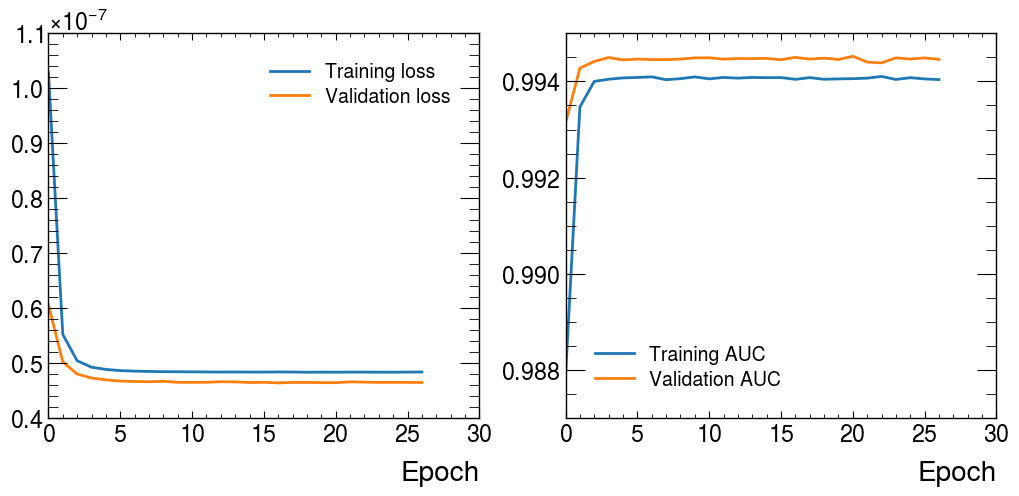

In [14]:
fig,ax=plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(history.history['loss'],label="Training loss")
ax[0].plot(history.history['val_loss'],label="Validation loss")
ax[0].set_xlabel("Epoch")
ax[0].legend(loc='best');

ax[1].plot(history.history['auc'],label="Training AUC")
ax[1].plot(history.history['val_auc'],label="Validation AUC")
ax[1].set_xlabel("Epoch")
ax[1].legend(loc='best'); 
plt.savefig("Training evaluation.pdf")

In [15]:
density=True
plt.hist(y_pred_model[NNTestLabel == 0],
         color='b', alpha=0.5,
         bins=30,
         histtype='stepfilled', density=density,
         #log=True,
         label='B (test)', weights=testWeights[NNTestLabel == 0])
plt.hist(y_pred_model[NNTestLabel == 1],
         color='r', alpha=0.5,
         bins=30,
         histtype='stepfilled', density=density,
         #log=True,
         label='S (test)', weights=testWeights[NNTestLabel == 1])
#plt.yscale('log')
plt.legend()
plt.title("NN model score");
plt.savefig("NN model score.pdf")
plt.show()

In [16]:
density=True
plt.hist(y_pred_model[NNTestLabel == 0],
         color='b', alpha=0.5,
         bins=30,
         histtype='stepfilled', density=density,
         #log=True,
         label='B (test)', weights=testWeights[NNTestLabel == 0])
plt.hist(y_pred_model[NNTestLabel == 1],
         color='r', alpha=0.5,
         bins=30,
         histtype='stepfilled', density=density,
         #log=True,
         label='S (test)', weights=testWeights[NNTestLabel == 1])
plt.yscale('log')
plt.legend()
plt.title("NN model score");
plt.savefig("NN model score.pdf")
plt.show()

In [17]:
my_plot_roc_curve(model, NNTestDataFinal_df, NNTestLabel)  

107547/107547 [==============================] - 118s 1ms/step


<Figure size 800x600 with 0 Axes>

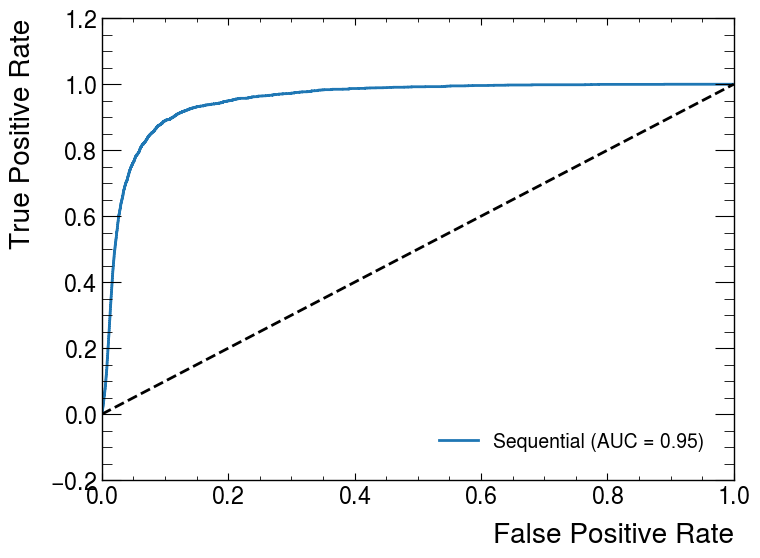

In [18]:
my_plot_roc_curve(model, testData_H, testLabel_H) 

testBackground['label']=0
testSignalG['label']=1

testData2=pd.concat([testSignalG,testBackground])
testLabel2=testData2['label']
testData2=testData2.drop(['label'],axis='columns')

my_plot_roc_curve(model, testData2, testLabel2)  

testBackground['label']=0
testSignalT['label']=1

testData2=pd.concat([testSignalT,testBackground])
testLabel2=testData2['label']
testData2=testData2.drop(['label'],axis='columns')

my_plot_roc_curve(model, testData2, testLabel2)  

testBackground['label']=0
testSignalM['label']=1
testData2=pd.concat([testSignalM,testBackground])
testLabel2=testData2['label']
testData2=testData2.drop(['label'],axis='columns')

my_plot_roc_curve(model, testData2, testLabel2)  

107547/107547 [==============================] - 122s 1ms/step
h auc: 0.9510565240888659
107502/107502 [==============================] - 118s 1ms/step
G auc: 0.9098637987692104
107550/107550 [==============================] - 119s 1ms/step
T auc: 0.8088277264292678
108223/108223 [==============================] - 120s 1ms/step
M auc: 0.9912780552241123


<Figure size 800x600 with 0 Axes>

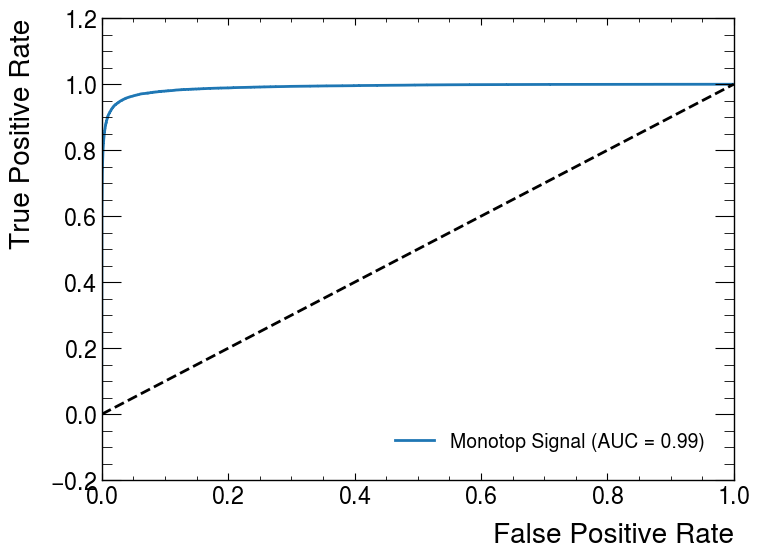

In [19]:
#finding h values 
if hasattr(model, "predict_proba"):
    y_scores = model.predict_proba(testData_H)
else:
    y_scores = model.predict(testData_H)
if len(y_scores.shape) == 2:
    if y_scores.shape[1] == 1:
        y_scores = y_scores.reshape(-1)
    elif y_scores.shape[1] == 2:
        y_scores = y_scores[:,1].reshape(-1)
fpr_H, tpr_H, _ = roc_curve(testLabel_H, y_scores)
roc_auc_H = roc_auc_score(testLabel_H, y_scores)

print("h auc:",roc_auc_H)

#finding g values 
if hasattr(model, "predict_proba"):
    y_scores = model.predict_proba(testData_G)
else:
    y_scores = model.predict(testData_G)
if len(y_scores.shape) == 2:
    if y_scores.shape[1] == 1:
        y_scores = y_scores.reshape(-1)
    elif y_scores.shape[1] == 2:
        y_scores = y_scores[:,1].reshape(-1)
fpr_G, tpr_G, _ = roc_curve(testLabel_G, y_scores)
roc_auc_G = roc_auc_score(testLabel_G, y_scores)

print("G auc:",roc_auc_G)

#finding t values 
if hasattr(model, "predict_proba"):
    y_scores = model.predict_proba(testData_T)
else:
    y_scores = model.predict(testData_T)
if len(y_scores.shape) == 2:
    if y_scores.shape[1] == 1:
        y_scores = y_scores.reshape(-1)
    elif y_scores.shape[1] == 2:
        y_scores = y_scores[:,1].reshape(-1)
fpr_T, tpr_T, _ = roc_curve(testLabel_T, y_scores)
roc_auc_T = roc_auc_score(testLabel_T, y_scores)

print("T auc:",roc_auc_T)

#finding m values
if hasattr(model, "predict_proba"):
    y_scores = model.predict_proba(testData_M)
else:
    y_scores = model.predict(testData_M)
if len(y_scores.shape) == 2:
    if y_scores.shape[1] == 1:
        y_scores = y_scores.reshape(-1)
    elif y_scores.shape[1] == 2:
        y_scores = y_scores[:,1].reshape(-1)
fpr_M, tpr_M, _ = roc_curve(testLabel_M, y_scores)
roc_auc_M = roc_auc_score(testLabel_M, y_scores)
print("M auc:",roc_auc_M)


plt.clf()
display = RocCurveDisplay(fpr=fpr_H, tpr=tpr_H, roc_auc=roc_auc_H, estimator_name="Higgs Signal")
display = RocCurveDisplay(fpr=fpr_G, tpr=tpr_G, roc_auc=roc_auc_G, estimator_name="Gluino Signal")
display = RocCurveDisplay(fpr=fpr_T, tpr=tpr_T, roc_auc=roc_auc_T, estimator_name="Triplet Signal")
display = RocCurveDisplay(fpr=fpr_M, tpr=tpr_M, roc_auc=roc_auc_M, estimator_name="Monotop Signal")
display.plot()
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.savefig("Roc Curve.pdf")
plt.show()

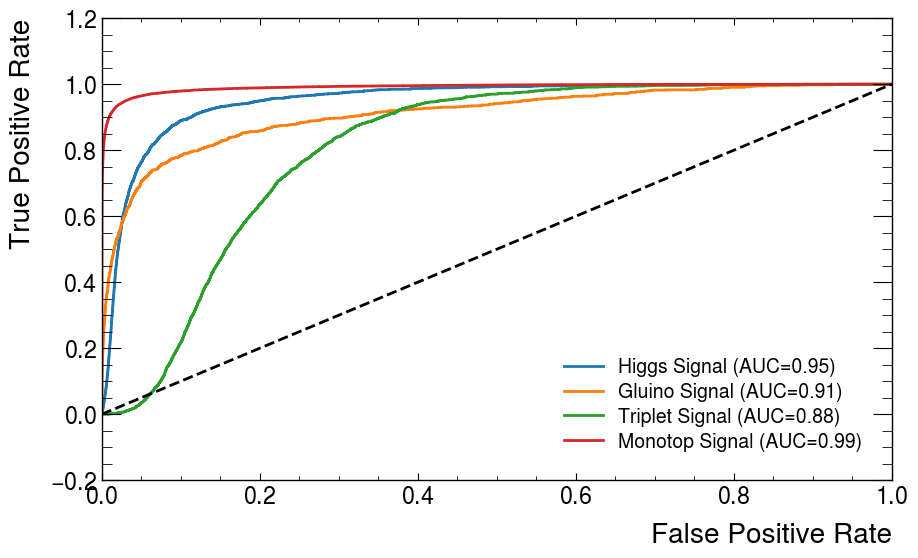

In [20]:
plt.figure(figsize=(10,6))
plt.plot(fpr_H,tpr_H,label=('Higgs Signal (AUC=0.95)'))
plt.plot(fpr_G,tpr_G,label=('Gluino Signal (AUC=0.91)'))
plt.plot(fpr_T,tpr_T,label=('Triplet Signal (AUC=0.88)'))
plt.plot(fpr_M,tpr_M,label=('Monotop Signal (AUC=0.99)'))
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()